In [3]:
%matplotlib inline

NOM: **OUSMANE**

PRENOMS: **MAHAMAT OUSMANE**


TItre : **Projet Réseaux de Neurones** :

***Classification de Fichiers
Audio***

Année: 2024-2025

**Master Statistqiue**

## I) **INTRODUCTION**

Cette étude consiste à faire une classification de fichiers audio contenus dans le dataset **SPEECHCOMMANDS**. En effet, la réalisation de cette étude s'appuie sur un tutoriel officiel où un réseau de neurones convolutionnel 1D est utilisé pour associer les données audio aux transcriptions.
Nous allons donc faire une transformation en spectrogramme à partir du quel nous allons concevoir un réseau de neurones convolutionnel 2D capable
de travailler sur les spectrogrammes pour faire la classification, tout en cherchant à optimiser ses performances.

In [4]:
import torch
import torchaudio
print(f"PyTorch version: {torch.__version__}")
print(f"TorchAudio version: {torchaudio.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.5.1+cu121
TorchAudio version: 2.5.1+cu121
CUDA available: True


In [5]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Current device: {torch.cuda.current_device()}" if torch.cuda.is_available() else "Using CPU")

CUDA available: True
Current device: 0


## II) **Importation des librairies nécessaires**

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torchaudio.transforms import MelSpectrogram
from torchaudio.datasets import SPEECHCOMMANDS
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import os



```
# Ce texte est au format code
```

## III) **Importation des données et quelques manipulations**

#### **Configuration des paramètres**
*batch_sizere: réprésente le nombre d'échantillons traités simultanément par le modèle lors d'une itération de la passe avant ( forward pass ) et arrière ( reverse pass ) pendant l'entraînement.En d'autres termes, chaque lot contient un sous-ensemble de données extrait du jeu d'entraînement.

*learning_rate:Le taux d’apprentissage, noté lr ou α, est un hyperparamètre crucial dans les réseaux de neurones qui contrôle la vitesse à laquelle les coefficients du modèle sont mis à jour lors de la phase d’apprentissage.

*step_size: permet de réduire le taux d'apprentissage après un certain nombre d'époques pour affiner les poids.

*n_fft: taille de la fenêtre pour le spectrogramme. Par exemple pour n_ftt=400 et un échantillonnage de 16 kHz , chaque fenêtre correspond à 400 / 16 000 = 0,025 secondes (25 ms).

*weight_decay: régularisation L2 pour éviter le sur-apprentissage, une sorte de pénalité.

*gamma: représente le multiplicateur appliqué au taux d'apprentissage à chaque étape définie par step_size. Par exemple, si le taux d'apprentissage initial (lr) est de 0.001et que gamma=0.1, alors après chaque step_size, le taux d'apprentissage sera réduit comme suit :   𝑙r_nouveau=𝑙r_ancien*gamma.

*hop_length: représente le nombre d'échantillons de décalage entre deux fenêtres consécutives lors du
calcul du spectrogramme.En d'autres termes, il contrôle l'espacement temporel entre les trames (frames) dans le spectrogramme.
Si n_fft=400 et hop_length=160, cela signifie qu'il ya un recouvrement de
𝑛_fft − longueur_du_saut=400−160=240 échantillons.



In [7]:
# Configuration globale avec explications
CONFIG = {
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),  # Utilisation de GPU si disponible
    "batch_size": 64,  # Nombre d'exemples par batch
    "n_mels_list": [32, 64, 128, 256],  # Différentes tailles de Mel bins pour visualisation
    "n_mels": 128,  # Valeur fixe choisie après analyse des spectrogrammes
    "n_fft": 512,  # Taille de la fenêtre FFT pour le spectrogramme
    "hop_length": 160,  # Décalage entre les fenêtres FFT
    "n_epochs": 10,  # Nombre total d'epochs pour l'entraînement
    "learning_rate": 0.001,  # Taux d'apprentissage initial
    "weight_decay": 0.0001,  # Régularisation L2
    "step_size": 5,  # Réduction du taux d'apprentissage tous les 5 epochs
    "gamma": 0.1,  # Facteur de réduction du taux d'apprentissage
    "sample_rate": 16000 # Adding the sample rate to the CONFIG dictionary
}

print(f"Using device: {CONFIG['device']}")

Using device: cuda


**Charger et séparer les données en ensembles d'entraînement et de test.**

In [8]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

100%|██████████| 2.26G/2.26G [01:42<00:00, 23.6MB/s]


**Afficher la forme (shape) et le taux d'échantillonnage (sample_rate) d'un signal audio (waveform).
Tracer graphiquement le signal audio dans le domaine temporel.**



Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


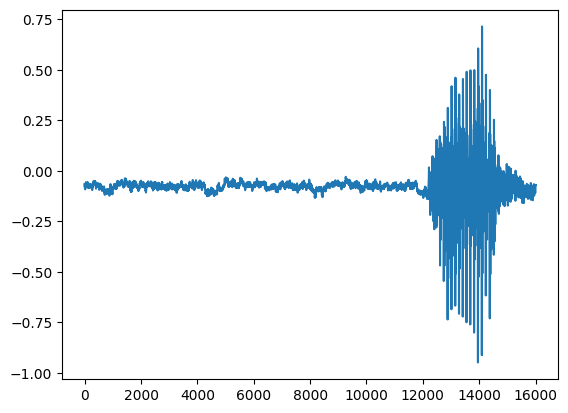

In [9]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

*Interprétation:

1 : Cela signifie que le signal est en mono (1 seul canal audio).

16000 : Cela représente le nombre total d'échantillons dans le signal audio.
Durée du signal :
Puisque le taux d'échantillonnage est de 16,000 Hz, le signal contient 1 seconde d'audio.

In [10]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

*Interprétation : Ce code permet d'extraire toutes les étiquettes uniques (ou labels) présentes dans le dataset d'entraînement train_set.

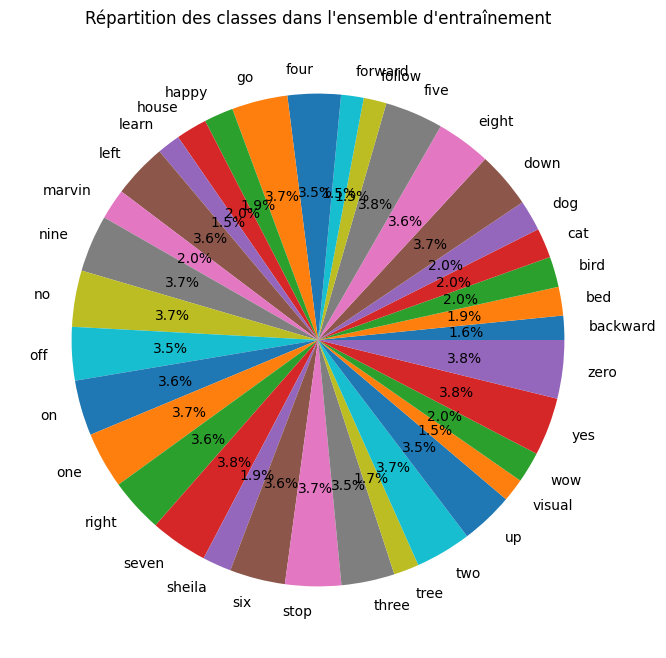

In [11]:
from collections import Counter


# Répartition des labels dans l'ensemble d'entraînement
label_counts = Counter(datapoint[2] for datapoint in train_set)

# Conversion pour le graphique
labels = list(label_counts.keys())
counts = list(label_counts.values())

# Tracé du camembert
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title("Répartition des classes dans l'ensemble d'entraînement")
plt.show()

*Interprétation: Ce cercle (diagramme en camembert) montre la répartition des classes dans l'ensemble d'entraînement.Chaque segment représente une classe unique parmi les commandes vocales disponibles dans le dataset (par exemple, "yes", "no", "up", etc.).
Les tailles des segments indiquent la proportion relative des occurrences de chaque classe dans l'ensemble d'entraînement. La répartition semble être relativement équilibrée, ce qui signifie que la plupart des classes ont des proportions proches, autour de 3-4%.Cela indique que le dataset ne souffre pas d'un déséquilibre sévère, ce qui est positif pour entraîner un modèle de classification. Un déséquilibre pourrait entraîner une baisse de performance pour les classes sous-représentées.



In [12]:
# Extraction des labels
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
def label_to_index(word):
    return torch.tensor(labels.index(word))

def index_to_label(index):
    return labels[index]

In [13]:
import IPython.display as ipd
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

In [14]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [ ]:
# Préparation des batches avec padding dynamique
#def collate_fn_dynamic(batch):
    #tensors, targets = [], []
    #for waveform, _, label, *_ in batch:
        #tensors.append(waveform)
        #targets.append(label_to_index(label))

    # Padding dynamique pour rendre toutes les séquences de la même longueur
    #tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True, padding_value=0.)
    #targets = torch.stack(targets)

    #return tensors, targets


## IV) **Classification**

### IV-1) **Normalisation et Transformation en spectrogramme**


La normalisation avant la transformation en spectrogramme est utile pour la classification d’audios car elle permet d’harmoniser les niveaux d’amplitude des signaux audio. Cela aide à éliminer les variations dues à des différences de volume entre les fichiers audio, ce qui peut fausser les résultats de classification.
La normalisation est donc un prétraitement important qui facilite la comparaison des signaux audio et améliore la précision des modèles de classification audio.

La transformation en spectrogramme dans le contexte des réseaux de neurones est une étape cruciale pour convertir des fichiers audio en une forme utilisable par ces modèles. Le spectrogramme est une représentation visuelle du spectre d’un son en fonction du temps. Il est généralement obtenu par une transformation de Fourier discrète (DFT), une transformation rapide de Fourier (FFT) ou une transformation discrète de cosinus (DCT).

Le processus de transformation en spectrogramme permet de convertir un fichier audio en une image qui peut être analysée par un réseau de neurones. Cette image représente le spectre sonore à différents moments, ce qui est utile pour l’identification de phonèmes ou la reconnaissance vocale.

Dans le cas d’une reconnaissance vocale, par exemple, le spectrogramme est utilisé pour extraire des caractéristiques des sons qui peuvent être utilisées pour différencier différents mots ou phonèmes. Les réseaux de neurones peuvent alors être formés à reconnaître ces caractéristiques pour effectuer des tâches comme la reconnaissance de la parole.

In [22]:
from torchaudio.transforms import MelSpectrogram

def get_mel_transform(n_mels, sample_rate=16000):
    """
    Crée une transformation MelSpectrogram avec les paramètres configurés.
    """
    return MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=CONFIG["n_fft"],
        hop_length=CONFIG["hop_length"],
        n_mels=n_mels
    )

In [18]:
def normalize_and_transform(waveform, n_mels, sample_rate=16000):
    """
    Normalise un waveform et le transforme en spectrogramme Mel.
    """
    normalized_waveform = normalize_waveform(waveform)
    mel_transform = get_mel_transform(n_mels, sample_rate)
    return mel_transform(normalized_waveform)

In [23]:
def normalize_waveform(waveform):
    """
    Normalizes the waveform to have a range between -1 and 1.
    """
    return waveform / torch.max(torch.abs(waveform))

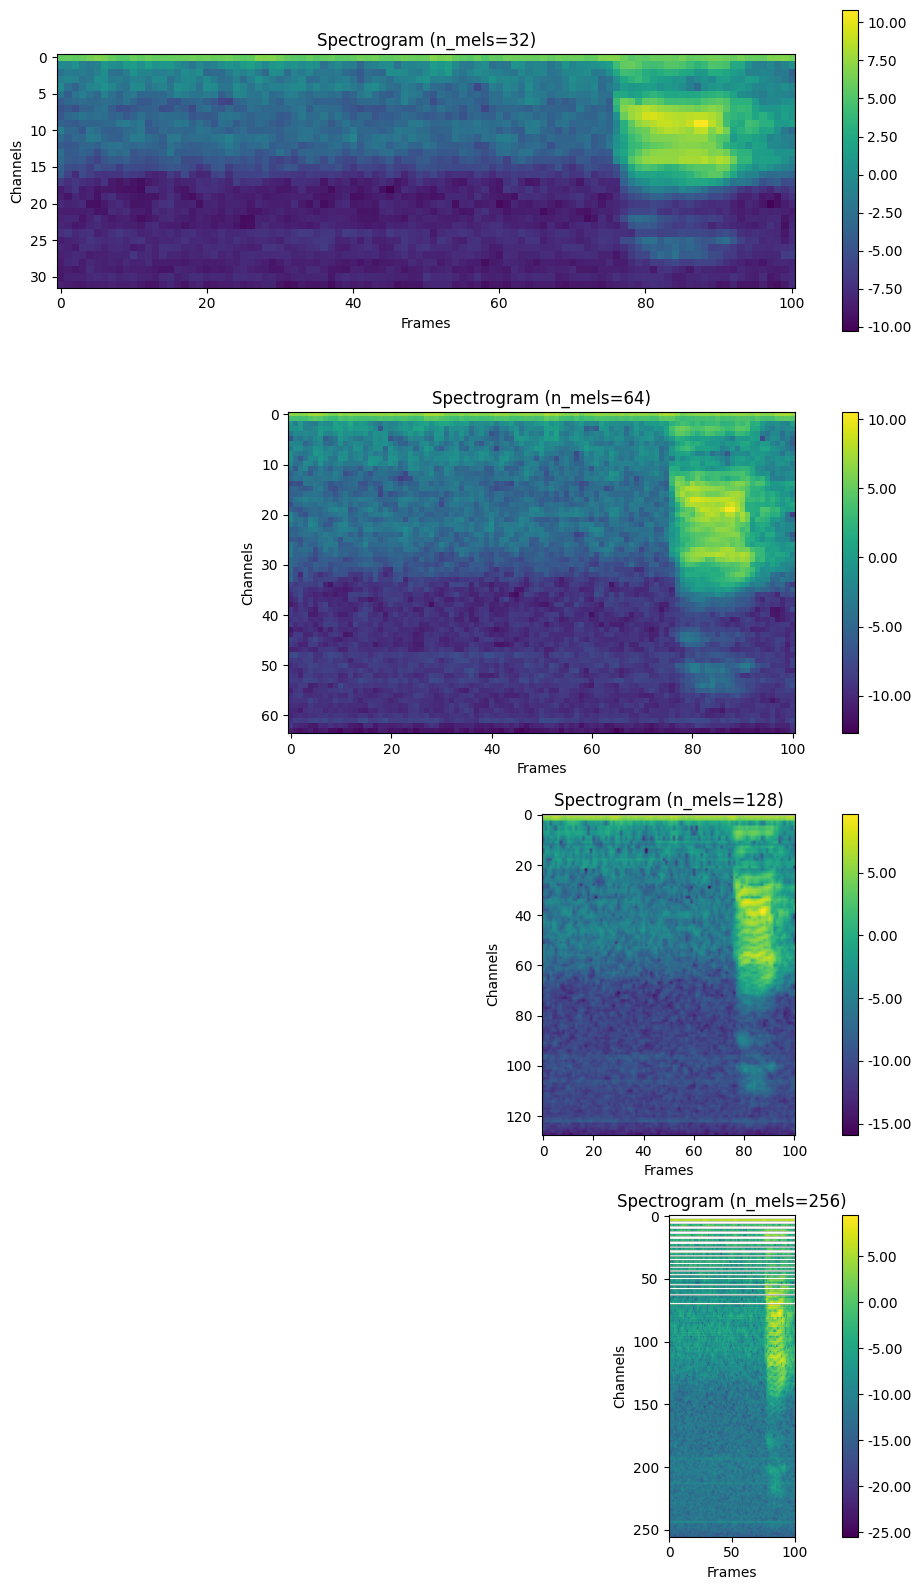

In [24]:
import matplotlib.pyplot as plt

def display_mel_spectrograms(waveform, sample_rate=16000):
    """
    Affiche les spectrogrammes Mel pour toutes les valeurs de `n_mels` dans CONFIG["n_mels_list"].
    """
    plt.figure(figsize=(10, len(CONFIG["n_mels_list"]) * 4))  # Taille ajustée dynamiquement
    for i, n_mels in enumerate(CONFIG["n_mels_list"], 1):
        # Transformation en spectrogramme
        spectrogram = normalize_and_transform(waveform, n_mels, sample_rate)

        # Affichage du spectrogramme
        plt.subplot(len(CONFIG["n_mels_list"]), 1, i)
        plt.imshow(spectrogram.log2()[0, :, :].cpu().numpy(), cmap="viridis")
        plt.title(f"Spectrogram (n_mels={n_mels})")
        plt.colorbar(format="%.2f")
        plt.xlabel("Frames")
        plt.ylabel("Channels")

    plt.tight_layout()
    plt.show()

# Exemple avec un fichier audio du jeu d'entraînement
waveform, sample_rate, label, *_ = train_set[0]  # Charger un exemple audio
waveform = normalize_waveform(waveform)  # Normaliser
display_mel_spectrograms(waveform, sample_rate=CONFIG["sample_rate"])

*Interprétation: on aimerait choisir n_mels = 128, car il offre un bon équilibre entre détails spectrographiques et gestion de la taille du spectrogramme pour le modèle CNN 2D. Il capture les détails nécessaires pour l'analyse spectrale tout en maintenant une résolution temporelle suffisante.
Équilibre entre complexité computationnelle et qualité des informations spectrales.



In [25]:
# Mettre à jour le paramètre n_mels dans CONFIG pour la suite
CONFIG["n_mels"] = 128  # Le meilleur n_mels choisi
print(f"Le n_mels choisi pour la suite est : {CONFIG['n_mels']}")


Le n_mels choisi pour la suite est : 128


### IV-2) **Le padding dynamique**
Le padding dynamique après la normalisation et la transformation en spectrogramme est une technique utilisée dans la classification audio pour s’assurer que toutes les entrées ont la même taille.cette technique permet de :

*Standardiser la taille des spectrogrammes, ce qui facilite leur traitement par les réseaux de neurones.

*Conserver les informations sonores importantes tout en complétant les spectrogrammes plus courts avec des données neutres (zéros).

*Faciliter l’application de techniques de convolution et d’autres opérations de traitement d’images sur les spectrogrammes.


Cette étape est cruciale pour la préparation des données avant leur entrée dans un modèle de machine learning, assurant ainsi une meilleure performance de classification.


In [26]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn_dynamic_after_transform(batch, mel_transform):
    """
    Applique un padding dynamique après transformation en spectrogrammes.
    """
    spectrograms = []
    labels = []

    for waveform, _, label, *_ in batch:
        # Transformation en spectrogramme avec n_mels=128
        spectrogram = mel_transform(waveform)
        spectrograms.append(spectrogram.squeeze(0).t())  # Transpose pour (Frames, Channels)
        labels.append(label_to_index(label))

    # Appliquer un padding dynamique
    spectrograms = pad_sequence(spectrograms, batch_first=True, padding_value=0.0).permute(0, 2, 1)
    labels = torch.tensor(labels)

    return spectrograms, labels

# Création du transformateur Mel pour n_mels=128
mel_transform = get_mel_transform(n_mels=128)

# Exemple d'intégration avec un DataLoader
train_loader = DataLoader(
    train_set,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    collate_fn=lambda batch: collate_fn_dynamic_after_transform(batch, mel_transform),
    num_workers=2 if CONFIG["device"].type == "cuda" else 0,
    pin_memory=CONFIG["device"].type == "cuda"
)

test_loader = DataLoader(
    test_set,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    collate_fn=lambda batch: collate_fn_dynamic_after_transform(batch, mel_transform),
    num_workers=2 if CONFIG["device"].type == "cuda" else 0,
    pin_memory=CONFIG["device"].type == "cuda"
)

print("DataLoaders configurés avec padding dynamique pour n_mels=128.")

DataLoaders configurés avec padding dynamique pour n_mels=128.


### IV-3) **Modèle Réseau de neuronnes convolutionnel 2D**

In [27]:
class CNN2D(nn.Module):
    def __init__(self, n_input=1, n_output=len(labels), n_channel=32):
        super(CNN2D, self).__init__()
        # Change n_input to match the number of channels in your data
        # n_input should be 1, as mel spectrograms have 1 channel
        self.conv1 = nn.Conv2d(n_input, n_channel, kernel_size=(3, 3), padding=(1, 1))
        self.conv2 = nn.Conv2d(n_channel, n_channel * 2, kernel_size=(3, 3), padding=(1, 1))
        self.conv3 = nn.Conv2d(n_channel * 2, n_channel * 4, kernel_size=(3, 3), padding=(1, 1))
        self.pool = nn.MaxPool2d((2, 2))

        # Initialisation temporaire pour fc1, sera ajustée dynamiquement
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, n_output)

    def forward(self, x):
        # x.unsqueeze(1) adds a channel dimension to the input
        x = x.unsqueeze(1)  # Reshape to (batch_size, 1, n_mels, time_frames)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten

        # Ajuster fc1 dynamiquement si nécessaire
        input_size = x.shape[1]
        if self.fc1.in_features != input_size:
            self.fc1 = nn.Linear(input_size, 128).to(x.device)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [28]:
# Initialisation du modèle
model = CNN2D(n_input=1, n_output=len(labels))
model.to(CONFIG["device"])

# Fonction pour calculer la taille aplatie
def compute_flatten_size(model, input_shape):
    with torch.no_grad():
        dummy_input = torch.zeros(1, *input_shape).to(CONFIG["device"])
        output = model.pool(model.pool(model.pool(model.conv3(model.conv2(model.conv1(dummy_input))))))
        return output.view(1, -1).shape[1]

flatten_size = compute_flatten_size(model, (1, CONFIG["n_mels"], 101))  # 101 : taille arbitraire après padding
model.fc1 = nn.Linear(flatten_size, 128)
model.to(CONFIG["device"])

print("Modèle CNN2D initialisé avec succès.")
print(model)

Modèle CNN2D initialisé avec succès.
CNN2D(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=24576, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=35, bias=True)
)


*Interprétation: Ce modèle extrait des caractéristiques pertinentes des spectrogrammes Mel, en transformant les informations brutes en représentations intermédiaires plus compactes via les couches convolutions et poolings.
Les couches fully connected utilisent ces représentations pour effectuer la classification finale parmi les 35 commandes vocales.


In [29]:
optimizer = optim.Adam(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=CONFIG["weight_decay"])
scheduler = lr_scheduler.StepLR(optimizer, step_size=CONFIG["step_size"], gamma=CONFIG["gamma"])
criterion = nn.CrossEntropyLoss()

print("Optimiseur, scheduler et fonction de perte configurés.")


Optimiseur, scheduler et fonction de perte configurés.


*Interprétation:

L'optimiseur Adam ajuste les paramètres du modèle pour minimiser la perte.

Le scheduler ajuste dynamiquement le taux d'apprentissage pour maximiser les performances.

La CrossEntropyLoss quantifie l'erreur entre les prédictions et les labels, servant de signal à l'optimiseur.

Ces composants travaillent ensemble pour garantir que le modèle converge efficacement et apprend à effectuer correctement les prédictions.

In [30]:
def train(model, epoch, log_interval=10):
    model.train()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(CONFIG["device"]), target.to(CONFIG["device"])

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if log_interval > 0 and batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                  f"({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
    # Return the average loss after the loop has completed.
    return total_loss / len(train_loader)

def test(model, epoch):
    model.eval()
    correct = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(CONFIG["device"]), target.to(CONFIG["device"])
            output = model(data)
            total_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = 100. * correct / len(test_loader.dataset)
    avg_loss = total_loss / len(test_loader.dataset)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} "
          f"({accuracy:.2f}%)\tAverage Loss: {avg_loss:.6f}\n")

    return accuracy, avg_loss

In [31]:
train_losses = []
test_accuracies = []

print("Début de l'entraînement...")
for epoch in range(1, CONFIG["n_epochs"] + 1):
    train_loss = train(model, epoch, log_interval=0)  # log_interval=0 pour désactiver les logs détaillés
    train_losses.append(train_loss)

    test_accuracy, test_loss = test(model, epoch)
    test_accuracies.append(test_accuracy)

    scheduler.step()

    print(f"Époque {epoch}/{CONFIG['n_epochs']} - "
          f"Perte moyenne (Entraînement) : {train_loss:.4f} | "
          f"Précision (Test) : {test_accuracy:.2f}%")

print("Entraînement terminé !")

Début de l'entraînement...

Test Epoch: 1	Accuracy: 7888/11005 (71.68%)	Average Loss: 0.015244

Époque 1/10 - Perte moyenne (Entraînement) : 1.6860 | Précision (Test) : 71.68%

Test Epoch: 2	Accuracy: 8631/11005 (78.43%)	Average Loss: 0.011494

Époque 2/10 - Perte moyenne (Entraînement) : 0.7303 | Précision (Test) : 78.43%

Test Epoch: 3	Accuracy: 8980/11005 (81.60%)	Average Loss: 0.009986

Époque 3/10 - Perte moyenne (Entraînement) : 0.5401 | Précision (Test) : 81.60%

Test Epoch: 4	Accuracy: 9039/11005 (82.14%)	Average Loss: 0.009794

Époque 4/10 - Perte moyenne (Entraînement) : 0.4372 | Précision (Test) : 82.14%

Test Epoch: 5	Accuracy: 8975/11005 (81.55%)	Average Loss: 0.010569

Époque 5/10 - Perte moyenne (Entraînement) : 0.3556 | Précision (Test) : 81.55%

Test Epoch: 6	Accuracy: 9366/11005 (85.11%)	Average Loss: 0.009306

Époque 6/10 - Perte moyenne (Entraînement) : 0.1942 | Précision (Test) : 85.11%

Test Epoch: 7	Accuracy: 9370/11005 (85.14%)	Average Loss: 0.009747

Époque 7/1

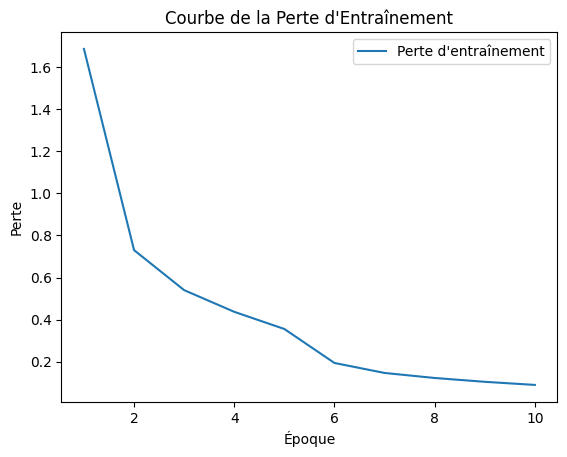

In [32]:
#Courbe de la perte d'entraînement
plt.figure()
plt.plot(range(1, CONFIG["n_epochs"] + 1), train_losses, label='Perte d\'entraînement')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.title('Courbe de la Perte d\'Entraînement')
plt.legend()
plt.show()



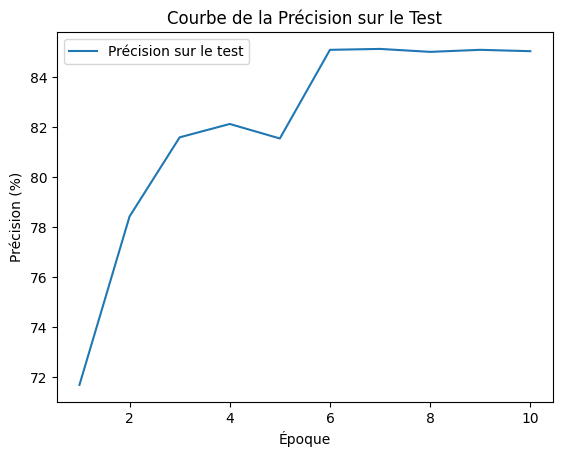

In [33]:
# Courbe de la précision sur le test
plt.figure()
plt.plot(range(1, CONFIG["n_epochs"] + 1), test_accuracies, label='Précision sur le test')
plt.xlabel('Époque')
plt.ylabel('Précision (%)')
plt.title('Courbe de la Précision sur le Test')
plt.legend()
plt.show()

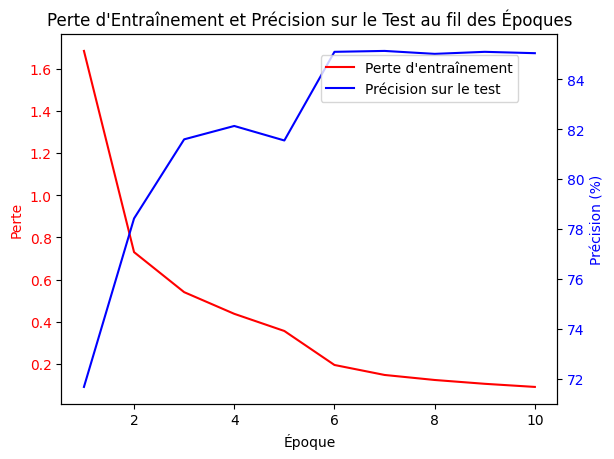

In [34]:
# Création d'une figure et d'un axe
import matplotlib.pyplot as plt # Importing the library for plotting.

# Création d'une figure et d'un axe
fig, ax1 = plt.subplots()

# Tracé de la courbe de perte d'entraînement en rouge
ax1.plot(range(1, CONFIG["n_epochs"] + 1), train_losses, 'r-', label='Perte d\'entraînement')
ax1.set_xlabel('Époque')
ax1.set_ylabel('Perte', color='r')
ax1.tick_params(axis='y', labelcolor='r')

# Création d'un second axe partageant le même axe x
ax2 = ax1.twinx()
ax2.plot(range(1, CONFIG["n_epochs"] + 1), test_accuracies, 'b-', label='Précision sur le test')
ax2.set_ylabel('Précision (%)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Ajout des légendes
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))

# Titre du graphique
plt.title('Perte d\'Entraînement et Précision sur le Test au fil des Époques')

# Affichage du graphique
plt.show()

*Interprétation:

Cette courbe montre `l'évolution de la perte d'entraînement (en rouge) et de la précision sur le test (en bleu) au fil des époques (10 époques) d'entraînement.

La perte diminue rapidement au début, ce qui indique que le modèle apprend efficacement les caractéristiques des données.
Cette diminution ralentit au fil des époques, suggérant que le modèle converge progressivement vers un minimum de perte.
Une perte print(d'entraînement faible signifie que le modèle s'ajuste bien aux données d'entraînement).

La précision augmente rapidement au début, atteignant un plateau après quelques époques.
Ce plateau indique que le modèle commence à atteindre ses performances maximales sur les données de test.
La petite fluctuation vers les époques (4-6) peut être causée par un ajustement trop précis sur les données
d'entraînement, mais cela reste maîtrisé.

Corrélation entre la perte et la précision :

La diminution de la perte d'entraînement est accompagnée d'une augmentation de la précision sur le test, ce
qui montre que le modèle généralise bien.La stabilisation des deux courbes indique que le modèle a
atteint un équilibre entre l'apprentissage et la généralisation.

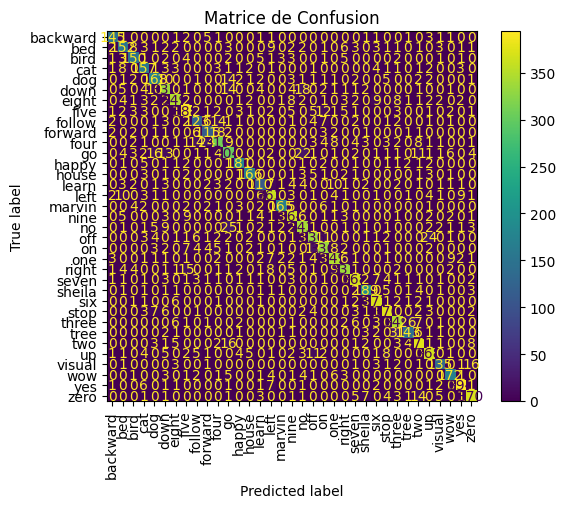

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def plot_confusion_matrix(model, data_loader, labels):
    """
    Génère et affiche la matrice de confusion pour les prédictions du modèle.
    """
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(CONFIG["device"])
            target = target.to(CONFIG["device"])
            output = model(data)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # Calcul de la matrice de confusion
    cm = confusion_matrix(all_targets, all_preds)

    # Affichage
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="viridis", xticks_rotation="vertical")
    plt.title("Matrice de Confusion")
    plt.show()

# Exemple d'utilisation
plot_confusion_matrix(model, test_loader, labels)

*Interprétation: La matrice de confusion affichée montre les performances du modèle de classification
sur l'ensemble de test pour chaque classe. Voici une analyse détaillée :

Les valeurs élevées sur la diagonale principale indiquent que le modèle a une bonne précision globale pour de nombreuses classes.
Ces classes sont bien modélisées par le réseau.
Ainsi, les classes backward, yes, et dog par exemple ont des scores élevés sur la diagonale principale, ce qui indique que le modèle les prédit avec une grande précision.
Ces classes peuvent avoir des caractéristiques audio distinctes, rendant leur classification plus facile.

Les valeurs hors diagonale montrent les erreurs. Par exemple :
La classe marvin est parfois confondue avec nine, comme indiqué par la valeur non nulle dans la ligne marvin et la colonne nine.
La classe dog est légèrement confondue avec cat.
Les confusions entre certaines classes comme marvin et nine ou dog et cat montrent que certaines classes ont des spectrogrammes ou des patterns similaires.
Ces erreurs peuvent être dues à un manque de données ou à des caractéristiques partagées entre les classes.



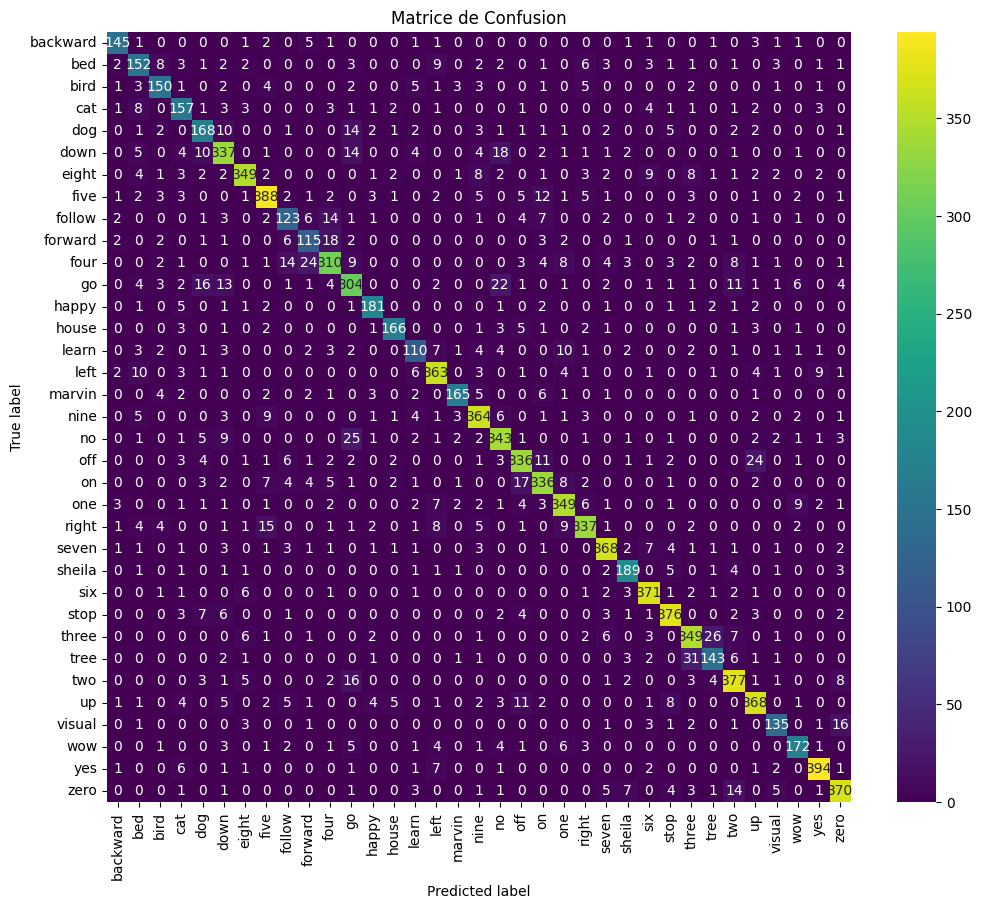

In [40]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# Fonction pour générer et afficher la matrice de confusion
def generate_confusion_matrix(model, dataloader, classes):
    """
    Génère et affiche une matrice de confusion pour le modèle donné et le jeu de test.
    """
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in dataloader:
            # Déplacement des données vers le dispositif approprié (CPU ou GPU)
            data, target = data.to(CONFIG["device"]), target.to(CONFIG["device"])
            # Prédictions
            output = model(data)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # Calcul de la matrice de confusion
    cm = confusion_matrix(all_targets, all_preds)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    # Visualisation avec Seaborn
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap="viridis", cbar=True)
    plt.title("Matrice de Confusion")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

# Exemple d'utilisation après l'entraînement du modèle
generate_confusion_matrix(model, test_loader, labels)

*Interprétation: cette matrice de confusion a été générée avant l'entraînement, mais cela
n'aurait pas beaucoup de sens, car elle ne représenterait pas les prédictions du modèle entraîné.
Elle pourrait éventuellement refléter des prédictions aléatoires ou un modèle non entraîné.
Bien que les deux matrices diffèrent légèrement dans les valeurs spécifiques, elles sont similaires dans
leur structure générale.

### **Code pour sauvegarde les pois du modèle entrainé**

Ce fichier (cnn2d_model_weights.pth) contient les poids du modèle entraîné, qui pourront être rechargés ultérieurement pour effectuer des tests ou d'autres analyses.

In [ ]:
# Sauvegarde des poids du modèle entraîné
model_save_path = "cnn2d_model_weights.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Poids du modèle sauvegardés dans {model_save_path}")

### ****Code pour télécharger le fichier sur l'ordinateur****

In [43]:
from google.colab import files
files.download(model_save_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## V) Conclusion:

Le projet a permis de démontrer l'efficacité d'un réseau de neurones convolutionnel 2D pour la classification audio basée sur des spectrogrammes. Bien que les résultats soient prometteurs, une amélioration des performances reste possible grâce à des techniques avancées et une exploration approfondie des hyperparamètres. Ce projet constitue une base solide pour des recherches futures dans le domaine de la reconnaissance vocale ou de l'analyse sonore.